# 01 - Data Profiling

**Objective**: Comprehensive data quality assessment for Customer Churn Prediction

**Outputs**:
- Data quality report (shape, memory, duplicates)
- Missing value analysis with visualization
- Churn baseline and class imbalance assessment
- Zero-variance feature detection

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print('Libraries loaded successfully!')

Libraries loaded successfully!


## 1. Load Data

In [ ]:
# Define paths
RAW_DATA_PATH = Path('../data/01_raw')
INTERMEDIATE_PATH = Path('../data/02_intermediate')
REPORTING_PATH = Path('../data/08_reporting')

# Create directories if they don't exist
INTERMEDIATE_PATH.mkdir(parents=True, exist_ok=True)
REPORTING_PATH.mkdir(parents=True, exist_ok=True)

# Load training data
train_file = RAW_DATA_PATH / 'cell2celltrain.csv'
holdout_file = RAW_DATA_PATH / 'cell2cellholdout.csv'

print(f"Loading data from: {train_file}")
df_train = pd.read_csv(train_file)
print(f"Loading holdout from: {holdout_file}")
df_holdout = pd.read_csv(holdout_file)

print(f"\n Training data loaded: {df_train.shape[0]:,} rows, {df_train.shape[1]} columns")
print(f" Holdout data loaded: {df_holdout.shape[0]:,} rows, {df_holdout.shape[1]} columns")

Loading data from: ..\data\01_raw\cell2celltrain.csv
Loading holdout from: ..\data\01_raw\cell2cellholdout.csv

 Training data loaded: 51,047 rows, 58 columns
 Holdout data loaded: 20,000 rows, 58 columns


## 2. Basic Data Overview

In [ ]:
def generate_basic_profile(df, name='Dataset'):
    """Generate basic data profile."""
    profile = {
        'Dataset': name,
        'Rows': df.shape[0],
        'Columns': df.shape[1],
        'Memory (MB)': df.memory_usage(deep=True).sum() / 1024**2,
        'Duplicate Rows': df.duplicated().sum(),
        'Total Missing Values': df.isnull().sum().sum(),
        'Missing %': (df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100
    }
    return profile

# Generate profiles
train_profile = generate_basic_profile(df_train, 'Training')
holdout_profile = generate_basic_profile(df_holdout, 'Holdout')

# Display as DataFrame
profile_df = pd.DataFrame([train_profile, holdout_profile])
print(" BASIC DATA PROFILE")
print("=" * 60)
display(profile_df)

 BASIC DATA PROFILE


,Dataset,Rows,Columns,Memory (MB),Duplicate Rows,Total Missing Values,Missing %
0,Training,51047,58,72.33,0,3515,0.12
1,Holdout,20000,58,27.51,0,21304,1.84


In [ ]:
# Check CustomerID uniqueness
print(" CUSTOMERID VALIDATION")
print("=" * 60)

if 'CustomerID' in df_train.columns:
    unique_ids = df_train['CustomerID'].nunique()
    total_ids = len(df_train['CustomerID'])
    duplicate_ids = total_ids - unique_ids
    
    print(f"Total CustomerIDs: {total_ids:,}")
    print(f"Unique CustomerIDs: {unique_ids:,}")
    print(f"Duplicate CustomerIDs: {duplicate_ids:,}")
    
    if duplicate_ids == 0:
        print("\n CustomerID is unique - no data leakage from duplicate customers")
    else:
        print(f"\n WARNING: {duplicate_ids} duplicate CustomerIDs found!")
else:
    print(" CustomerID column not found")

 CUSTOMERID VALIDATION
Total CustomerIDs: 51,047
Unique CustomerIDs: 51,047
Duplicate CustomerIDs: 0

 CustomerID is unique - no data leakage from duplicate customers


In [ ]:
# Display first few rows
print(" SAMPLE DATA (First 5 rows)")
print("=" * 60)
display(df_train.head())

 SAMPLE DATA (First 5 rows)


,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.00,22.00,0.25,0.00,0.00,-157.00,-19.00,0.70,0.70,6.30,0.00,0.00,97.20,0.00,0.00,58.00,24.00,1.30,0.00,0.30,61,2,1,SEAPOR503,2.00,2.00,361.00,62.00,0.00,No,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,1,0,No,No,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.00,17.00,0.00,0.00,0.00,-4.00,0.00,0.30,0.00,2.70,0.00,0.00,0.00,0.00,0.00,5.00,1.00,0.30,0.00,0.00,58,1,1,PITHOM412,2.00,1.00,1504.00,40.00,42.00,Yes,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,Yes,No,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.00,38.00,0.00,0.00,0.00,-2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.40,0.30,0.00,1.30,3.70,0.00,0.00,0.00,60,1,1,MILMIL414,1.00,1.00,1812.00,26.00,26.00,Yes,No,No,No,No,Unknown,No,No,No,No,No,Yes,0,0,Yes,No,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.00,75.00,1.24,0.00,0.00,157.00,8.10,52.00,7.70,76.00,4.30,1.30,200.30,370.30,147.00,555.70,303.70,59.70,0.00,22.70,59,2,2,PITHOM412,9.00,4.00,458.00,30.00,0.00,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,Yes,No,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.00,17.00,0.00,0.00,0.00,0.00,-0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,53,2,2,OKCTUL918,4.00,3.00,852.00,46.00,54.00,No,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,Yes,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


## 3. Data Types Analysis

In [ ]:
def analyze_dtypes(df):
    """Analyze data types and categorize features."""
    dtype_summary = df.dtypes.value_counts()
    
    # Categorize columns
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    boolean_cols = df.select_dtypes(include=['bool']).columns.tolist()
    
    return {
        'dtype_summary': dtype_summary,
        'numerical': numerical_cols,
        'categorical': categorical_cols,
        'boolean': boolean_cols
    }

dtype_analysis = analyze_dtypes(df_train)

print(" DATA TYPE SUMMARY")
print("=" * 60)
print(dtype_analysis['dtype_summary'])
print(f"\nNumerical columns: {len(dtype_analysis['numerical'])}")
print(f"Categorical columns: {len(dtype_analysis['categorical'])}")
print(f"Boolean columns: {len(dtype_analysis['boolean'])}")

 DATA TYPE SUMMARY
float64    26
object     23
int64       9
Name: count, dtype: int64

Numerical columns: 35
Categorical columns: 23
Boolean columns: 0


In [ ]:
# List all columns by type
print("\n NUMERICAL COLUMNS:")
print(", ".join(dtype_analysis['numerical'][:20]))
if len(dtype_analysis['numerical']) > 20:
    print(f"... and {len(dtype_analysis['numerical']) - 20} more")

print("\n CATEGORICAL COLUMNS:")
print(", ".join(dtype_analysis['categorical']))


 NUMERICAL COLUMNS:
CustomerID, MonthlyRevenue, MonthlyMinutes, TotalRecurringCharge, DirectorAssistedCalls, OverageMinutes, RoamingCalls, PercChangeMinutes, PercChangeRevenues, DroppedCalls, BlockedCalls, UnansweredCalls, CustomerCareCalls, ThreewayCalls, ReceivedCalls, OutboundCalls, InboundCalls, PeakCallsInOut, OffPeakCallsInOut, DroppedBlockedCalls
... and 15 more

 CATEGORICAL COLUMNS:
Churn, ServiceArea, ChildrenInHH, HandsetRefurbished, HandsetWebCapable, TruckOwner, RVOwner, Homeownership, BuysViaMailOrder, RespondsToMailOffers, OptOutMailings, NonUSTravel, OwnsComputer, HasCreditCard, NewCellphoneUser, NotNewCellphoneUser, OwnsMotorcycle, HandsetPrice, MadeCallToRetentionTeam, CreditRating, PrizmCode, Occupation, MaritalStatus


## 4. Target Variable Analysis (Churn)

In [8]:
# Identify target column
target_col = 'Churn'

if target_col in df_train.columns:
    print(" TARGET VARIABLE ANALYSIS")
    print("=" * 60)
    
    # Value counts
    churn_counts = df_train[target_col].value_counts()
    churn_pcts = df_train[target_col].value_counts(normalize=True) * 100
    
    print(f"\nChurn Distribution:")
    for val in churn_counts.index:
        label = "Churned" if val == 1 or val == 'Yes' else "Retained"
        print(f"  {label} ({val}): {churn_counts[val]:,} ({churn_pcts[val]:.2f}%)")
    
    # Calculate imbalance ratio
    minority_class = churn_counts.min()
    majority_class = churn_counts.max()
    imbalance_ratio = majority_class / minority_class
    churn_rate = churn_pcts.min() if 1 in churn_counts.index or 'Yes' in churn_counts.index else churn_pcts.iloc[1]
    
    print(f"\n Class Imbalance Metrics:")
    print(f"  Imbalance Ratio: {imbalance_ratio:.2f}:1")
    print(f"  Minority Class %: {100/imbalance_ratio:.2f}%")
    
    # Flag severity
    if churn_rate < 5:
        print("\n SEVERE IMBALANCE: Churn rate < 5% - Strong SMOTE/class weights needed")
    elif churn_rate > 40:
        print("\n HIGH CHURN RATE: > 40% - Verify data quality, may not need SMOTE")
    elif churn_rate >= 10 and churn_rate <= 25:
        print("\n TYPICAL TELECOM CHURN: 10-25% range - Standard handling")
    else:
        print(f"\n Churn rate: {churn_rate:.2f}% - Moderate imbalance")
else:
    print(f" Target column '{target_col}' not found in dataset")

 TARGET VARIABLE ANALYSIS

Churn Distribution:
  Retained (No): 36,336 (71.18%)
  Churned (Yes): 14,711 (28.82%)

 Class Imbalance Metrics:
  Imbalance Ratio: 2.47:1
  Minority Class %: 40.49%

 Churn rate: 28.82% - Moderate imbalance


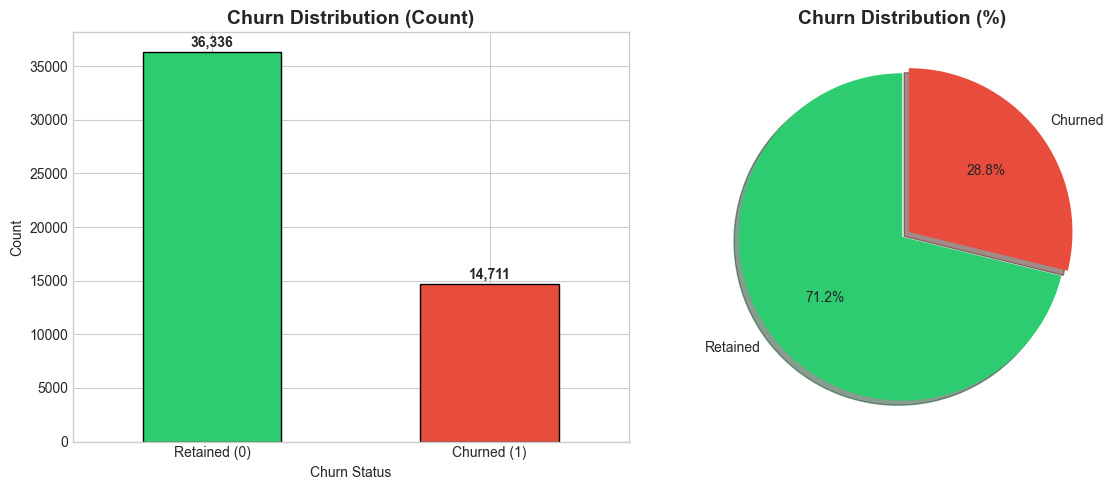


 Saved: ..\data\08_reporting\churn_distribution.png


In [9]:
# Visualize churn distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
ax1 = axes[0]
colors = ['#2ecc71', '#e74c3c']
churn_counts.plot(kind='bar', ax=ax1, color=colors, edgecolor='black')
ax1.set_title('Churn Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Churn Status')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Retained (0)', 'Churned (1)'], rotation=0)

# Add value labels
for i, v in enumerate(churn_counts.values):
    ax1.text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
ax2 = axes[1]
ax2.pie(churn_counts.values, labels=['Retained', 'Churned'], autopct='%1.1f%%',
        colors=colors, explode=[0, 0.05], shadow=True, startangle=90)
ax2.set_title('Churn Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(REPORTING_PATH / 'churn_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\n Saved: {REPORTING_PATH / 'churn_distribution.png'}")

## 5. Missing Value Analysis

In [10]:
def analyze_missing_values(df):
    """Comprehensive missing value analysis."""
    missing_count = df.isnull().sum()
    missing_pct = (df.isnull().sum() / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Column': missing_count.index,
        'Missing Count': missing_count.values,
        'Missing %': missing_pct.values,
        'Dtype': [str(df[col].dtype) for col in missing_count.index]
    })
    
    # Filter to only columns with missing values
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing %', ascending=False)
    
    # Add action recommendation
    def recommend_action(row):
        if row['Missing %'] > 30:
            return 'Consider dropping'
        elif row['Missing %'] > 5:
            return 'Impute + create flag'
        else:
            return 'Simple imputation'
    
    if len(missing_df) > 0:
        missing_df['Recommended Action'] = missing_df.apply(recommend_action, axis=1)
    
    return missing_df

missing_analysis = analyze_missing_values(df_train)

print(" MISSING VALUE ANALYSIS")
print("=" * 60)
print(f"\nColumns with missing values: {len(missing_analysis)}")
print(f"Total columns: {df_train.shape[1]}")
print(f"Complete columns: {df_train.shape[1] - len(missing_analysis)}")

if len(missing_analysis) > 0:
    display(missing_analysis.head(20))
else:
    print("\n No missing values found in the dataset!")

 MISSING VALUE ANALYSIS

Columns with missing values: 14
Total columns: 58
Complete columns: 44


,Column,Missing Count,Missing %,Dtype,Recommended Action
31,AgeHH2,909,1.78,float64,Simple imputation
30,AgeHH1,909,1.78,float64,Simple imputation
9,PercChangeRevenues,367,0.72,float64,Simple imputation
8,PercChangeMinutes,367,0.72,float64,Simple imputation
2,MonthlyRevenue,156,0.31,float64,Simple imputation
3,MonthlyMinutes,156,0.31,float64,Simple imputation
7,RoamingCalls,156,0.31,float64,Simple imputation
6,OverageMinutes,156,0.31,float64,Simple imputation
5,DirectorAssistedCalls,156,0.31,float64,Simple imputation
4,TotalRecurringCharge,156,0.31,float64,Simple imputation


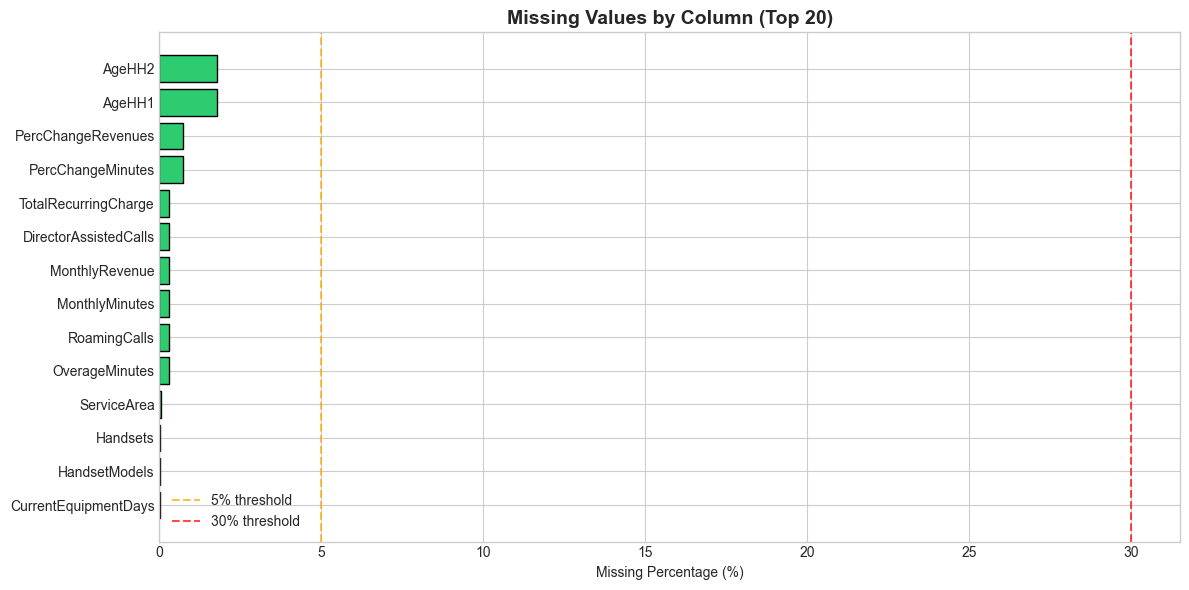


 Saved: ..\data\08_reporting\missing_values.png


In [11]:
# Visualize missing values
if len(missing_analysis) > 0:
    fig, ax = plt.subplots(figsize=(12, max(6, len(missing_analysis) * 0.3)))
    
    # Sort for better visualization
    plot_data = missing_analysis.head(20).sort_values('Missing %')
    
    colors = ['#e74c3c' if x > 30 else '#f39c12' if x > 5 else '#2ecc71' for x in plot_data['Missing %']]
    
    ax.barh(plot_data['Column'], plot_data['Missing %'], color=colors, edgecolor='black')
    ax.set_xlabel('Missing Percentage (%)')
    ax.set_title('Missing Values by Column (Top 20)', fontsize=14, fontweight='bold')
    
    # Add threshold lines
    ax.axvline(x=5, color='orange', linestyle='--', alpha=0.7, label='5% threshold')
    ax.axvline(x=30, color='red', linestyle='--', alpha=0.7, label='30% threshold')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(REPORTING_PATH / 'missing_values.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n Saved: {REPORTING_PATH / 'missing_values.png'}")

## 6. Numerical Features Summary

In [12]:
# Statistical summary for numerical columns
numerical_cols = dtype_analysis['numerical']

# Remove ID columns from analysis
numerical_cols = [col for col in numerical_cols if 'ID' not in col.upper()]

print(" NUMERICAL FEATURES SUMMARY")
print("=" * 60)

# Extended statistics
stats_df = df_train[numerical_cols].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T
stats_df['skew'] = df_train[numerical_cols].skew()
stats_df['kurtosis'] = df_train[numerical_cols].kurtosis()

display(stats_df.round(2))

 NUMERICAL FEATURES SUMMARY


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,skew,kurtosis
MonthlyRevenue,50891.00,58.83,44.51,-6.17,10.00,15.48,33.61,48.46,71.06,135.18,225.96,1223.38,4.18,41.00
MonthlyMinutes,50891.00,525.65,529.87,0.00,0.00,20.00,158.00,366.00,723.00,1576.50,2458.30,7359.00,2.19,8.11
TotalRecurringCharge,50891.00,46.83,23.85,-11.00,9.00,10.00,30.00,45.00,60.00,85.00,120.00,400.00,1.63,8.91
DirectorAssistedCalls,50891.00,0.90,2.23,0.00,0.00,0.00,0.00,0.25,0.99,4.21,9.65,159.39,13.57,599.25
OverageMinutes,50891.00,40.03,96.59,0.00,0.00,0.00,0.00,3.00,41.00,190.00,429.10,4321.00,8.11,158.01
RoamingCalls,50891.00,1.24,9.82,0.00,0.00,0.00,0.00,0.00,0.30,5.10,21.50,1112.40,57.88,5150.06
PercChangeMinutes,50680.00,-11.55,257.51,-3875.00,-848.00,-380.00,-83.00,-5.00,66.00,345.00,739.21,5192.00,-0.32,20.83
PercChangeRevenues,50680.00,-1.19,39.57,-1107.70,-104.52,-47.60,-7.10,-0.30,1.60,46.50,115.06,2483.50,7.89,453.44
DroppedCalls,51047.00,6.01,9.04,0.00,0.00,0.00,0.70,3.00,7.70,22.00,42.30,221.70,4.55,41.73
BlockedCalls,51047.00,4.09,10.95,0.00,0.00,0.00,0.00,1.00,3.70,17.00,47.00,384.30,9.79,168.29


In [13]:
# Identify key features for churn analysis
key_features = [
    'MonthlyRevenue', 'MonthlyMinutes', 'MonthsInService', 
    'TotalRecurringCharge', 'DroppedCalls', 'BlockedCalls',
    'CustomerCareCalls', 'OverageMinutes', 'RoamingCalls'
]

# Filter to existing columns
key_features = [f for f in key_features if f in df_train.columns]

print(" KEY FEATURE STATISTICS")
print("=" * 60)
display(df_train[key_features].describe().round(2))

 KEY FEATURE STATISTICS


,MonthlyRevenue,MonthlyMinutes,MonthsInService,TotalRecurringCharge,DroppedCalls,BlockedCalls,CustomerCareCalls,OverageMinutes,RoamingCalls
count,50891.00,50891.00,51047.00,50891.00,51047.00,51047.00,51047.00,50891.00,50891.00
mean,58.83,525.65,18.76,46.83,6.01,4.09,1.87,40.03,1.24
std,44.51,529.87,9.80,23.85,9.04,10.95,5.10,96.59,9.82
min,-6.17,0.00,6.00,-11.00,0.00,0.00,0.00,0.00,0.00
25%,33.61,158.00,11.00,30.00,0.70,0.00,0.00,0.00,0.00
50%,48.46,366.00,16.00,45.00,3.00,1.00,0.00,3.00,0.00
75%,71.06,723.00,24.00,60.00,7.70,3.70,1.70,41.00,0.30
max,1223.38,7359.00,61.00,400.00,221.70,384.30,327.30,4321.00,1112.40


## 7. Categorical Features Analysis

In [14]:
def analyze_categorical_features(df, categorical_cols):
    """Analyze cardinality and distribution of categorical features."""
    cat_analysis = []
    
    for col in categorical_cols:
        unique_count = df[col].nunique()
        mode_val = df[col].mode().iloc[0] if len(df[col].mode()) > 0 else None
        mode_pct = (df[col] == mode_val).sum() / len(df) * 100 if mode_val else 0
        missing_pct = df[col].isnull().sum() / len(df) * 100
        
        cat_analysis.append({
            'Column': col,
            'Unique Values': unique_count,
            'Mode': mode_val,
            'Mode %': mode_pct,
            'Missing %': missing_pct,
            'Cardinality': 'High' if unique_count > 10 else 'Low'
        })
    
    return pd.DataFrame(cat_analysis).sort_values('Unique Values', ascending=False)

categorical_cols = dtype_analysis['categorical']

if len(categorical_cols) > 0:
    cat_analysis = analyze_categorical_features(df_train, categorical_cols)
    
    print(" CATEGORICAL FEATURES ANALYSIS")
    print("=" * 60)
    display(cat_analysis)
    
    # Flag high-cardinality columns
    high_card = cat_analysis[cat_analysis['Cardinality'] == 'High']['Column'].tolist()
    if high_card:
        print(f"\n HIGH CARDINALITY COLUMNS (>10 unique): {high_card}")
        print("   → Recommend: Target encoding with 5-fold CV")
else:
    print("No categorical columns found.")

 CATEGORICAL FEATURES ANALYSIS


,Column,Unique Values,Mode,Mode %,Missing %,Cardinality
1,ServiceArea,747,NYCBRO917,3.30,0.05,High
17,HandsetPrice,16,Unknown,56.78,0.00,High
21,Occupation,8,Other,73.73,0.00,Low
19,CreditRating,7,2-High,37.21,0.00,Low
20,PrizmCode,4,Other,48.30,0.00,Low
22,MaritalStatus,3,Unknown,38.59,0.00,Low
0,Churn,2,No,71.18,0.00,Low
6,RVOwner,2,No,91.86,0.00,Low
5,TruckOwner,2,No,81.34,0.00,Low
4,HandsetWebCapable,2,Yes,90.20,0.00,Low



 HIGH CARDINALITY COLUMNS (>10 unique): ['ServiceArea', 'HandsetPrice']
   → Recommend: Target encoding with 5-fold CV


## 8. Zero-Variance Feature Detection

In [15]:
def detect_zero_variance_features(df, threshold=0.01):
    """Detect features with zero or near-zero variance."""
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    variance_analysis = []
    for col in numerical_cols:
        var = df[col].var()
        unique_ratio = df[col].nunique() / len(df)
        
        variance_analysis.append({
            'Column': col,
            'Variance': var,
            'Unique Ratio': unique_ratio,
            'Flag': 'Zero/Low Variance' if var < threshold else 'OK'
        })
    
    var_df = pd.DataFrame(variance_analysis)
    zero_var = var_df[var_df['Flag'] == 'Zero/Low Variance']
    
    return var_df, zero_var

var_df, zero_var_features = detect_zero_variance_features(df_train)

print(" ZERO/LOW VARIANCE FEATURE DETECTION")
print("=" * 60)

if len(zero_var_features) > 0:
    print(f"\n Found {len(zero_var_features)} zero/low variance features:")
    display(zero_var_features)
else:
    print("\n No zero-variance features detected.")

 ZERO/LOW VARIANCE FEATURE DETECTION

 No zero-variance features detected.


## 9. Data Leakage Check

In [16]:
# Check for potential data leakage from retention-related features
print(" DATA LEAKAGE CHECK")
print("=" * 60)

leakage_suspects = ['RetentionCalls', 'RetentionOffersAccepted', 'MadeCallToRetentionTeam']
found_leakage_features = [col for col in leakage_suspects if col in df_train.columns]

if found_leakage_features:
    print(f"\n POTENTIAL LEAKAGE FEATURES FOUND:")
    for col in found_leakage_features:
        print(f"   - {col}")
    
    print("\n RECOMMENDATION: Exclude these features from modeling.")
    print("   Reason: Retention calls occur BECAUSE churn risk was detected.")
    print("   This creates temporal leakage (effect before cause).")
    
    # Show correlation with target
    if target_col in df_train.columns:
        print("\n Correlation with Churn:")
        for col in found_leakage_features:
            if df_train[col].dtype in ['int64', 'float64']:
                corr = df_train[col].corr(df_train[target_col])
                print(f"   {col}: {corr:.4f}")
else:
    print("\n No obvious leakage features detected.")

 DATA LEAKAGE CHECK

 POTENTIAL LEAKAGE FEATURES FOUND:
   - RetentionCalls
   - RetentionOffersAccepted
   - MadeCallToRetentionTeam

 RECOMMENDATION: Exclude these features from modeling.
   Reason: Retention calls occur BECAUSE churn risk was detected.
   This creates temporal leakage (effect before cause).

 Correlation with Churn:


ValueError: could not convert string to float: 'Yes'

## 10. Save Data Profile Report

In [ ]:
# Compile and save data profile
profile_report = {
    'basic_profile': profile_df,
    'missing_values': missing_analysis,
    'categorical_analysis': cat_analysis if len(categorical_cols) > 0 else pd.DataFrame(),
    'numerical_stats': stats_df
}

# Save to CSV
for name, df in profile_report.items():
    if isinstance(df, pd.DataFrame) and len(df) > 0:
        output_path = INTERMEDIATE_PATH / f'data_profile_{name}.csv'
        df.to_csv(output_path, index=True)
        print(f" Saved: {output_path}")

print("\n Data profiling complete!")

## 11. Summary & Next Steps

In [ ]:
# Generate summary
print("="*70)
print(" DATA PROFILING SUMMARY")
print("="*70)

print(f"\n Dataset Size: {df_train.shape[0]:,} rows × {df_train.shape[1]} columns")
print(f" Memory Usage: {df_train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Churn rate
if target_col in df_train.columns:
    churn_rate = df_train[target_col].mean() * 100
    print(f"\n Churn Rate: {churn_rate:.2f}%")

# Missing values
print(f"\n Missing Values: {len(missing_analysis)} columns affected")

# Leakage features
print(f"\n Leakage Features to Exclude: {found_leakage_features}")

print("\n" + "="*70)
print(" NEXT STEPS: Proceed to 02_EDA.ipynb for exploratory analysis")
print("="*70)